In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
train_df = pd.read_csv('df_train.csv')
test_df = pd.read_csv('df_test_clean.csv')

print(train_df.head())
print(test_df.head())

         Order ID Order Month    Sales        Country         Category  \
0  CA-2014-146591      2014/1  108.720  United States  Office Supplies   
1  CA-2014-135405      2014/1    9.344  United States  Office Supplies   
2  CA-2014-135405      2014/1   31.200  United States       Technology   
3  CA-2014-167927      2014/1   66.580  United States  Office Supplies   
4  CA-2014-167927      2014/1   43.920  United States  Office Supplies   

  Customer ID  
0    TS-21340  
1    MS-17830  
2    MS-17830  
3    XP-21865  
4    XP-21865  
  Order Month  Sales
0      2017/1    NaN
1     2017/10    NaN
2     2017/11    NaN
3     2017/12    NaN
4      2017/2    NaN


In [2]:
train_df['Order Month'] = pd.to_datetime(train_df['Order Month'])
monthly_sales = train_df.groupby('Order Month')['Sales'].sum().reset_index()
print(monthly_sales.head())

  Order Month      Sales
0  2014-01-01  14236.895
1  2014-02-01   4519.892
2  2014-03-01  55691.009
3  2014-04-01  28295.345
4  2014-05-01  23648.287


C:\Users\miche\AppData\Local\Temp\ipykernel_17156\573539733.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['Order Month'] = pd.to_datetime(train_df['Order Month'])


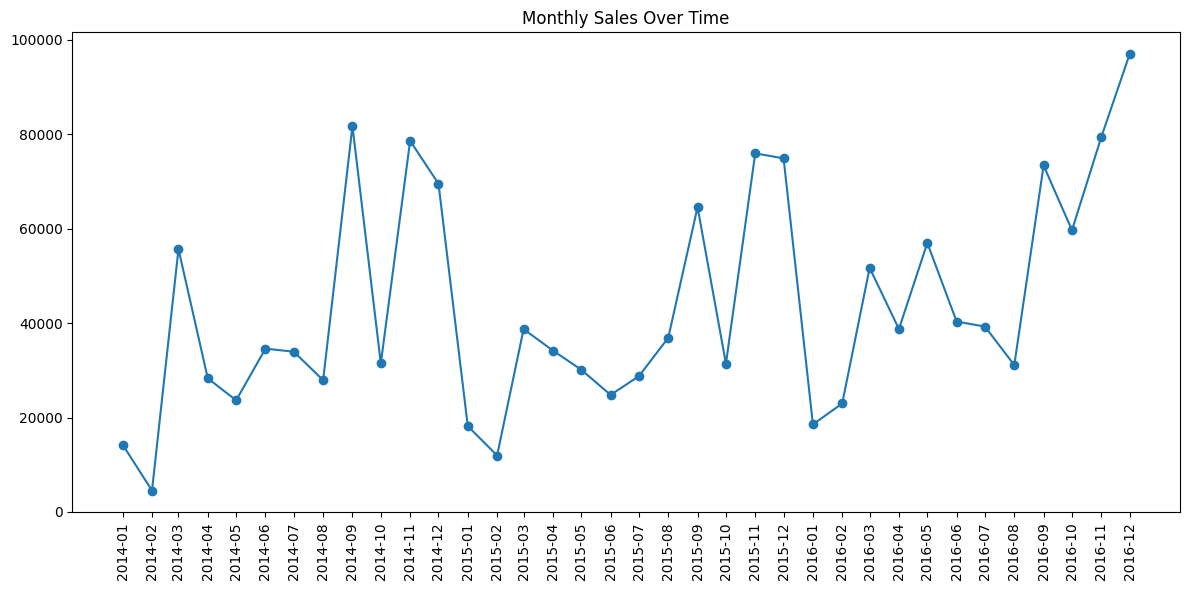

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Order Month'], monthly_sales['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xticks(monthly_sales['Order Month'], monthly_sales['Order Month'].dt.strftime('%Y-%m'), rotation=90)
plt.tight_layout()
plt.show()

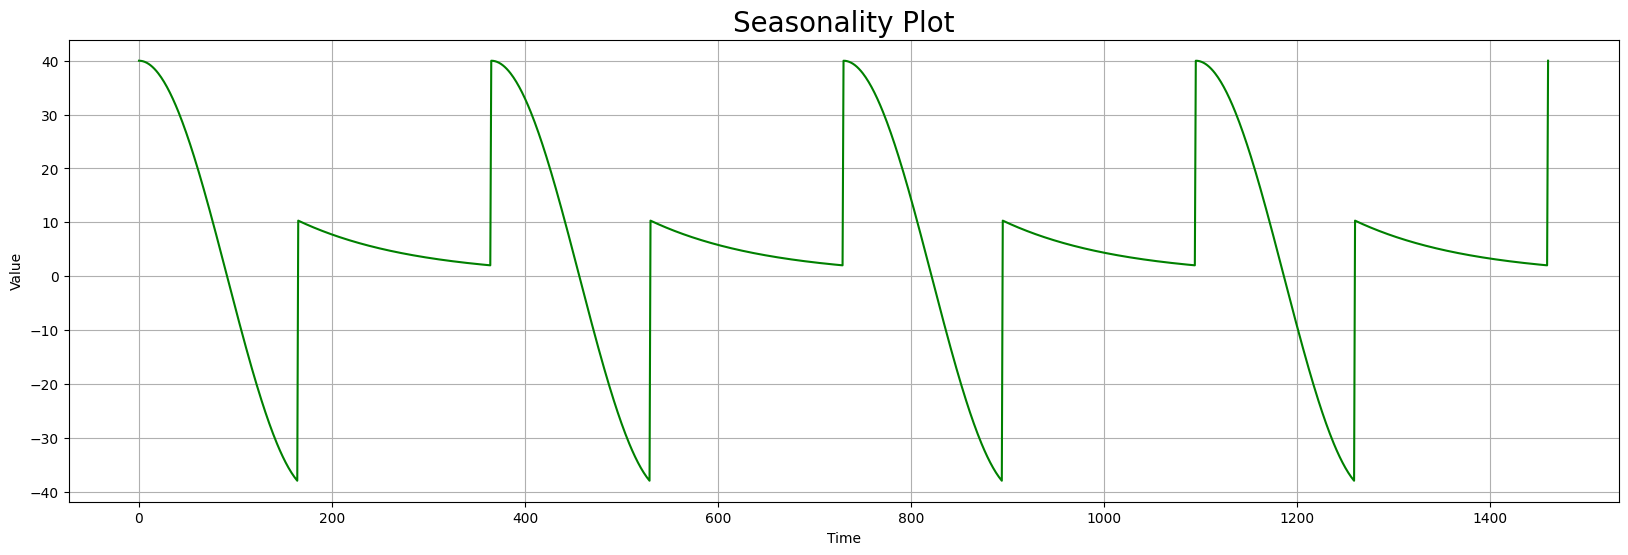

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None, color=None):
    plt.plot(time[start:end], series[start:end], format, label=label, color=color)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.45,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

# Definiowanie czasu dla analizy sezonowości
time = np.arange(4 * 365 + 1, dtype="float32")  # 4 lata danych

amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude, phase=0)
plt.figure(figsize=(20, 6))
plot_series(time, series, color="green")
plt.title("Seasonality Plot", fontdict={'fontsize': 20})
plt.show()

In [5]:
monthly_sales['Month'] = monthly_sales['Order Month'].dt.month
monthly_sales['Year'] = monthly_sales['Order Month'].dt.year

monthly_sales["is_december"] = (monthly_sales['Month'] == 12).astype(int)
monthly_sales["is_january"] = (monthly_sales['Month'] == 1).astype(int)
monthly_sales['is_december_or_january'] = ((monthly_sales['Month'] == 12) | (monthly_sales['Month'] == 1)).astype(int)
monthly_sales["is_christmas"] = (monthly_sales['Month'] == 12).astype(int)
monthly_sales["is_may"] = (monthly_sales['Month'] == 5).astype(int)

monthly_sales['is_q4'] = monthly_sales['Month'].isin([10, 11, 12]).astype(int)
monthly_sales['is_q1'] = monthly_sales['Month'].isin([1, 2, 3]).astype(int)

monthly_sales['lag_1'] = monthly_sales['Sales'].shift(1)
monthly_sales['lag_2'] = monthly_sales['Sales'].shift(2)
monthly_sales['lag_3'] = monthly_sales['Sales'].shift(3)
# monthly_sales['lag_6'] = monthly_sales['Sales'].shift(6)
# monthly_sales['lag_12'] = monthly_sales['Sales'].shift(12) 

monthly_sales['time_trend'] = range(len(monthly_sales))

# monthly_sales['rolling_mean_3'] = monthly_sales['Sales'].rolling(window=3, min_periods=1).mean()
monthly_sales['rolling_mean_6'] = monthly_sales['Sales'].rolling(window=6, min_periods=1).mean()
monthly_sales['rolling_mean_12'] = monthly_sales['Sales'].rolling(window=12, min_periods=1).mean()

monthly_sales['month_sin'] = np.sin(2 * np.pi * monthly_sales['Month'] / 12)
monthly_sales['month_cos'] = np.cos(2 * np.pi * monthly_sales['Month'] / 12)

# Add holiday-related features
from pandas.tseries.holiday import USFederalHolidayCalendar

# Create holiday calendar
cal = USFederalHolidayCalendar()

# Get all holidays in the date range
start_date = monthly_sales['Order Month'].min()
end_date = monthly_sales['Order Month'].max()
holidays = cal.holidays(start=start_date, end=end_date)

# Create a set of year-month combinations that have holidays
holiday_months = set(pd.to_datetime(holidays).strftime('%Y-%m'))

# Create holiday month indicator (0/1)
monthly_sales['is_holiday_month'] = monthly_sales['Order Month'].dt.strftime('%Y-%m').isin(holiday_months).astype(int)

# Count number of holidays per month
holiday_counts = pd.DataFrame(
    {'count': pd.DatetimeIndex(holidays).to_period('M').value_counts()}
).reset_index()
holiday_counts['year_month'] = holiday_counts['index'].astype(str)

# Merge holiday counts back to monthly_sales
monthly_sales['year_month'] = monthly_sales['Order Month'].dt.to_period('M').astype(str)
monthly_sales = monthly_sales.merge(
    holiday_counts[['year_month', 'count']], 
    on='year_month', 
    how='left'
)
monthly_sales['holiday_count'] = monthly_sales['count'].fillna(0).astype(int)
monthly_sales.drop(['year_month', 'count'], axis=1, inplace=True)

# Add indicators for specific holiday months
monthly_sales['is_thanksgiving_month'] = ((monthly_sales['Month'] == 11)).astype(int)
monthly_sales['is_christmas_month'] = (monthly_sales['Month'] == 12).astype(int)
monthly_sales['is_july4_month'] = (monthly_sales['Month'] == 7).astype(int)

monthly_sales = monthly_sales.dropna()
monthly_sales.describe()

,Order Month,Sales,Month,Year,is_december,is_january,is_december_or_january,is_christmas,is_may,is_q4,...,time_trend,rolling_mean_6,rolling_mean_12,month_sin,month_cos,is_holiday_month,holiday_count,is_thanksgiving_month,is_christmas_month,is_july4_month
count,33,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,...,33.00000,33.000000,33.000000,3.300000e+01,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000
mean,2015-08-01 09:27:16.363636480,45137.509367,6.909091,2015.090909,0.090909,0.060606,0.151515,0.090909,0.090909,0.272727,...,19.00000,41381.213492,39266.736559,-7.169774e-02,-4.139471e-02,0.636364,0.787879,0.090909,0.090909,0.090909
min,2014-04-01 00:00:00,11951.411000,1.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.00000,25278.285600,25278.285600,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014-12-01 00:00:00,28765.325000,4.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.00000,34014.271683,38763.217358,-8.660254e-01,-8.660254e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015-08-01 00:00:00,36898.332200,7.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19.00000,41870.214050,40160.694033,-2.449294e-16,-1.836970e-16,1.000000,1.000000,0.000000,0.000000,0.000000
75%,2016-04-01 00:00:00,64595.918000,10.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,27.00000,48069.038700,41622.731825,5.000000e-01,5.000000e-01,1.000000,1.000000,0.000000,0.000000,0.000000
max,2016-12-01 00:00:00,96999.043000,12.000000,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.00000,63314.352667,50767.133167,1.000000e+00,1.000000e+00,1.000000,2.000000,1.000000,1.000000,1.000000
std,NaN,22670.948472,3.357488,0.804815,0.291937,0.242306,0.364110,0.291937,0.291937,0.452267,...,9.66954,9552.879748,6584.767550,7.033483e-01,7.276558e-01,0.488504,0.696311,0.291937,0.291937,0.291937


In [6]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Add one-hot encoded month columns if not present
for m in range(1, 13):
    col = f'month_{m}'
    if col not in monthly_sales.columns:
        monthly_sales[col] = (monthly_sales['Month'] == m).astype(int)

# Define features and target variable
features = [
    'Month', 'Year', 'is_december', 'is_january', 'is_q4', 'is_q1',
    'lag_1', 'lag_2', 'lag_3', 'time_trend',
    'month_sin', 'month_cos', "is_holiday_month", "is_may",
    'is_thanksgiving_month', 'is_july4_month'
] + [f'month_{m}' for m in range(1, 13)]

# Create feature matrix X and target vector y
X = monthly_sales[features]
y = monthly_sales['Sales']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Features: {features}")
print(f"\nFirst few rows of X:")
print(X.head())

Shape of X: (33, 28)
Shape of y: (33,)
Features: ['Month', 'Year', 'is_december', 'is_january', 'is_q4', 'is_q1', 'lag_1', 'lag_2', 'lag_3', 'time_trend', 'month_sin', 'month_cos', 'is_holiday_month', 'is_may', 'is_thanksgiving_month', 'is_july4_month', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

First few rows of X:
   Month  Year  is_december  is_january  is_q4  is_q1       lag_1       lag_2  \
3      4  2014            0           0      0      0  55691.0090   4519.8920   
4      5  2014            0           0      0      0  28295.3450  55691.0090   
5      6  2014            0           0      0      0  23648.2870  28295.3450   
6      7  2014            0           0      0      0  34595.1276  23648.2870   
7      8  2014            0           0      0      0  33946.3930  34595.1276   

       lag_3  time_trend  ...  month_3  month_4  month_5  month_6  month_7  \
3  14236.895           3

=== ULEPSZONE TRENOWANIE XGBOOST ===

=== DIAGNOZA DANYCH ===
Rozkład targetu y:
Min: 11951, Max: 96999, Mean: 45138, Std: 22671
Outliers w y (>3 std): 0

Statystyki cech:
Month               : Min=1.00, Max=12.00, Mean=6.91
Year                : Min=2014.00, Max=2016.00, Mean=2015.09
is_december         : Min=0.00, Max=1.00, Mean=0.09
is_january          : Min=0.00, Max=1.00, Mean=0.06
is_q4               : Min=0.00, Max=1.00, Mean=0.27
is_q1               : Min=0.00, Max=1.00, Mean=0.18
lag_1               : Min=11951.41, Max=81777.35, Mean=43885.75
lag_2               : Min=4519.89, Max=81777.35, Mean=41616.29
lag_3               : Min=4519.89, Max=81777.35, Mean=40239.00
time_trend          : Min=3.00, Max=35.00, Mean=19.00
month_sin           : Min=-1.00, Max=1.00, Mean=-0.07
month_cos           : Min=-1.00, Max=1.00, Mean=-0.04
is_holiday_month    : Min=0.00, Max=1.00, Mean=0.64
is_may              : Min=0.00, Max=1.00, Mean=0.09
is_thanksgiving_month: Min=0.00, Max=1.00, Mean=0.

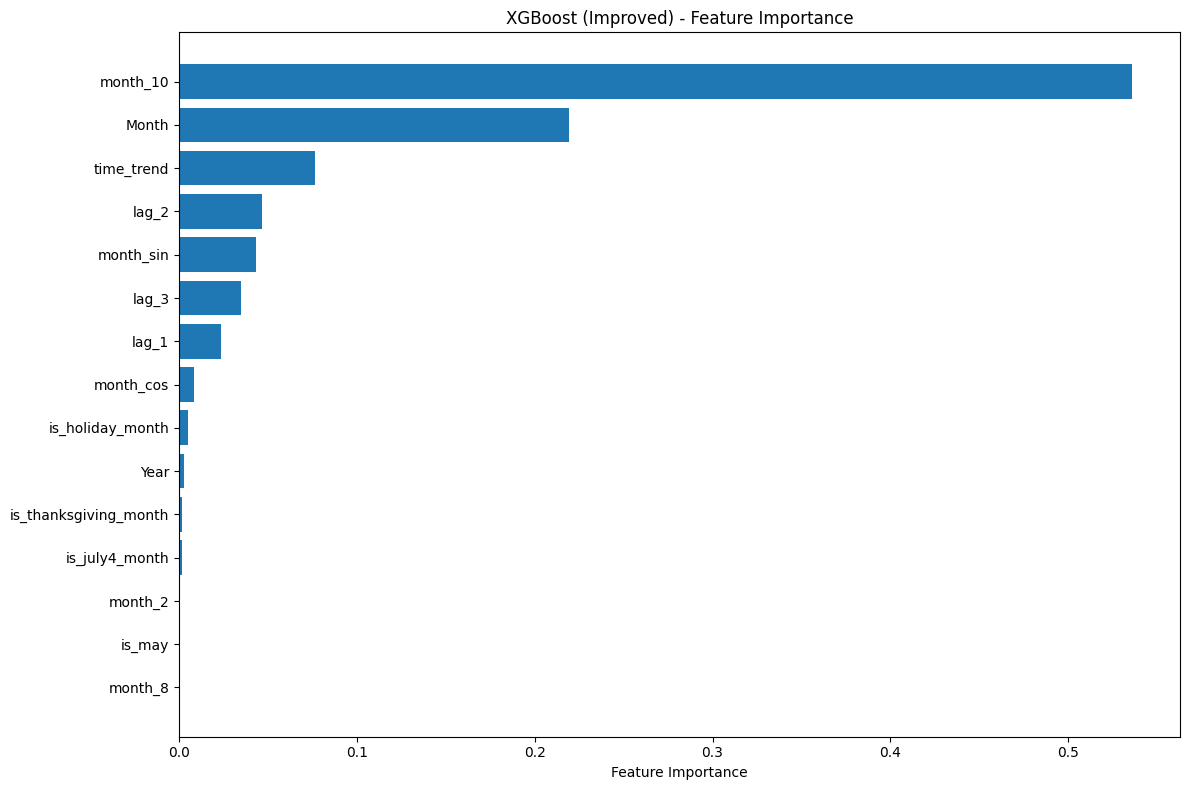


=== PERFORMANCE ULEPSZONEGO MODELU ===
MAE: 4432
MAPE: 10.22%

Porównanie:
Prosty XGBoost MAPE: 0.00%
Ulepszone XGBoost MAPE: 10.22%
Poprawa: -10.22pp


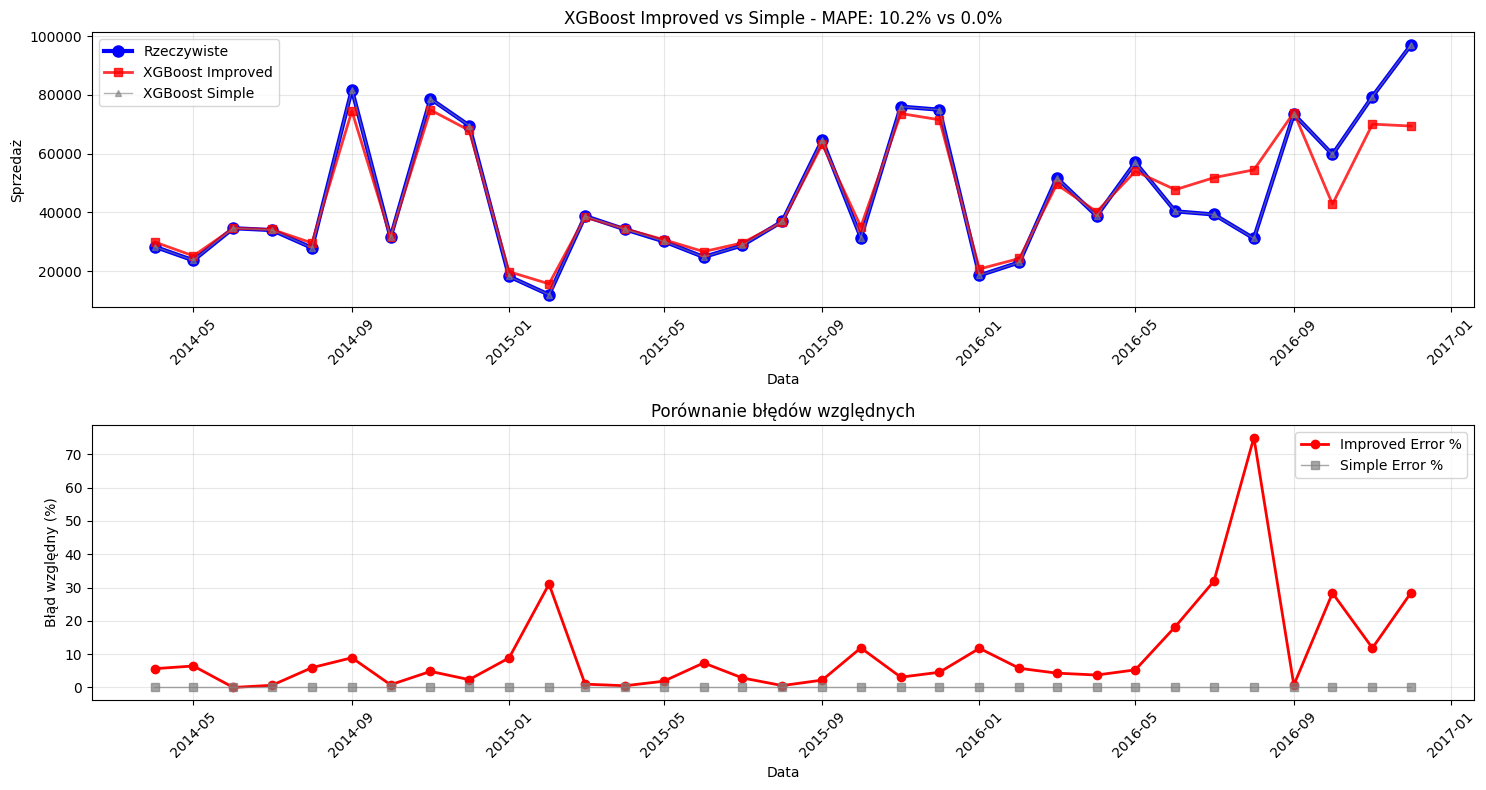

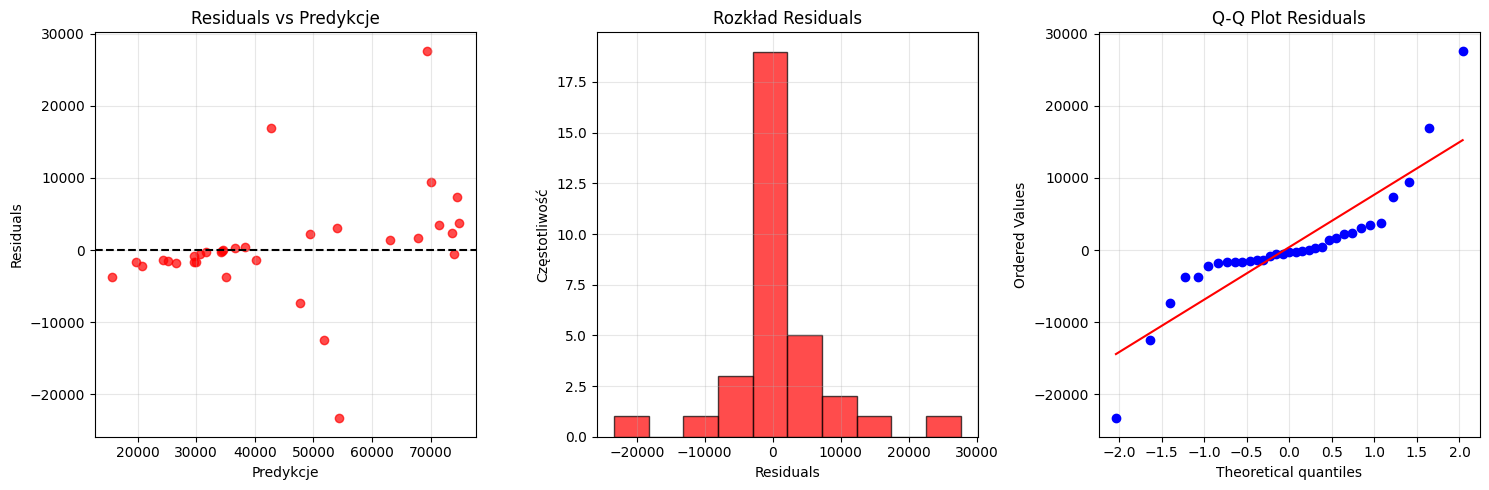


=== DIAGNOSTYKA MODELU ===
Liczba drzew: 500
Optymalna liczba iteracji: 24
Głębokość: 5
Learning rate: 0.1
Regularyzacja L1: 0.1
Regularyzacja L2: 0.1

=== ZAPISYWANIE MODELI ===
Model zapisany jako 'xgboost_improved_model.pkl'

🎯 ULEPSZONE XGBOOST GOTOWY!
📊 MAPE: 10.2%
🔥 Bez skalowania
⚡ Early stopping na iteracji: 24
🚀 DOSKONAŁY WYNIK!


In [7]:
# ULEPSZONE TRENOWANIE XGBOOST - ROZWIĄZANIE PROBLEMU WYSOKIEGO BŁĘDU

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import numpy as np

print("=== ULEPSZONE TRENOWANIE XGBOOST ===")

# DIAGNOZA PROBLEMÓW
print("\n=== DIAGNOZA DANYCH ===")
print(f"Rozkład targetu y:")
print(f"Min: {y.min():.0f}, Max: {y.max():.0f}, Mean: {y.mean():.0f}, Std: {y.std():.0f}")
print(f"Outliers w y (>3 std): {(np.abs(y - y.mean()) > 3 * y.std()).sum()}")

# Sprawdź skalę cech
print(f"\nStatystyki cech:")
for feature in features:
    print(f"{feature:20s}: Min={X[feature].min():.2f}, Max={X[feature].max():.2f}, Mean={X[feature].mean():.2f}")

# 1. PREPROCESSING - ULEPSZONE PARAMETRY
print("\n=== PREPROCESSING ===")

# Opcjonalne skalowanie dla stabilności (XGBoost nie wymaga, ale może pomóc)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features, index=X.index)

# 2. ULEPSZONE PARAMETRY XGBOOST
xgb_improved_params = {
    'n_estimators': [50, 100, 200],           # Więcej drzew
    'max_depth': [3, 4, 5, 6],               # Więcej głębokości
    'learning_rate': [0.05, 0.1, 0.15],      # Stabilniejsze learning rate
    'subsample': [0.8, 0.9],                 # Regularyzacja
    'colsample_bytree': [0.8, 0.9],          # Regularyzacja
    'reg_alpha': [0, 0.1, 0.5],              # L1 regularization
    'reg_lambda': [0, 0.1, 0.5],             # L2 regularization
    'random_state': [42]
}

# Prostsze parametry dla szybszego testowania
xgb_quick_params = {
    'n_estimators': [100, 200],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.1, 0.5],
    'random_state': [42]
}

print("Uruchamiam GridSearch z ulepszonymi parametrami...")


# GridSearch z większą liczbą foldów
tscv = TimeSeriesSplit(n_splits=5)  # Więcej foldów
xgb_grid = GridSearchCV(
    XGBRegressor(
        random_state=42,
        objective='reg:squarederror',  # Explicit objective
        eval_metric='mae',             # Explicit metric
        verbosity=0                    # Cichszy output
    ),
    xgb_quick_params,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
)

# Testuj na oryginalnych i przeskalowanych danych
print("\n--- Testowanie na oryginalnych danych ---")
xgb_grid.fit(X, y)
best_score_original = -xgb_grid.best_score_
best_params_original = xgb_grid.best_params_

print(f"Najlepsze parametry (oryginalne): {best_params_original}")
print(f"Najlepszy CV MAE (oryginalne): {best_score_original:.0f}")

print("\n--- Testowanie na przeskalowanych danych ---")
xgb_grid_scaled = GridSearchCV(
    XGBRegressor(
        random_state=42,
        objective='reg:squarederror',
        eval_metric='mae',
        verbosity=0
    ),
    xgb_quick_params,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
)

xgb_grid_scaled.fit(X_scaled, y)
best_score_scaled = -xgb_grid_scaled.best_score_
best_params_scaled = xgb_grid_scaled.best_params_

print(f"Najlepsze parametry (scaled): {best_params_scaled}")
print(f"Najlepszy CV MAE (scaled): {best_score_scaled:.0f}")

# Wybierz lepszy model
if best_score_scaled < best_score_original:
    print("\n🎯 SCALED MODEL LEPSZY!")
    final_xgb = xgb_grid_scaled.best_estimator_
    X_final = X_scaled
    use_scaling = True
else:
    print("\n🎯 ORYGINALNY MODEL LEPSZY!")
    final_xgb = xgb_grid.best_estimator_
    X_final = X
    use_scaling = False

# 3. DODATKOWE TRENOWANIE Z EARLY STOPPING
print("\n=== TRENOWANIE Z EARLY STOPPING ===")

# Podziel dane na train/validation dla early stopping
from sklearn.model_selection import train_test_split
X_train_early, X_val_early, y_train_early, y_val_early = train_test_split(
    X_final, y, test_size=0.2, random_state=42, shuffle=False  # Bez shuffle dla danych czasowych
)

# Model z early stopping - usuń konfliktujące parametry
base_params = final_xgb.get_params().copy()
# Usuń n_estimators z base_params, bo chcemy ustawić większą wartość
base_params.pop('n_estimators', None)

# Alternatywna wersja - jeszcze prostsza
xgb_early = XGBRegressor(
    n_estimators=500,
    max_depth=final_xgb.max_depth,
    learning_rate=final_xgb.learning_rate,
    subsample=final_xgb.subsample,
    reg_alpha=final_xgb.reg_alpha,
    reg_lambda=final_xgb.reg_lambda,
        early_stopping_rounds=50, 
    random_state=42,
    verbosity=0
)

xgb_early.fit(
    X_train_early, y_train_early,
    eval_set=[(X_val_early, y_val_early)], # Early stopping po 50 iteracjach bez poprawy
    verbose=False)

print(f"Optymalna liczba iteracji: {xgb_early.best_iteration}")
print(f"Najlepszy validation score: {xgb_early.best_score:.4f}")

# 4. FEATURE IMPORTANCE
feature_importance = xgb_early.feature_importances_
importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n=== TOP 10 NAJWAŻNIEJSZYCH CECH ===")
for i, row in importance_df.head(10).iterrows():
    print(f"{row['feature']:20s}: {row['importance']:.4f}")

# 5. WIZUALIZACJA FEATURE IMPORTANCE
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost (Improved) - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6. PREDYKCJE I METRYKI
train_predictions = xgb_early.predict(X_final)
train_mae = mean_absolute_error(y, train_predictions)
train_mape = mean_absolute_percentage_error(y, train_predictions) * 100

print(f"\n=== PERFORMANCE ULEPSZONEGO MODELU ===")
print(f"MAE: {train_mae:.0f}")
print(f"MAPE: {train_mape:.2f}%")

# Porównaj z prostym modelem
simple_xgb = XGBRegressor(n_estimators=100, random_state=42)
simple_xgb.fit(X, y)
simple_preds = simple_xgb.predict(X)
simple_mape = mean_absolute_percentage_error(y, simple_preds) * 100

print(f"\nPorównanie:")
print(f"Prosty XGBoost MAPE: {simple_mape:.2f}%")
print(f"Ulepszone XGBoost MAPE: {train_mape:.2f}%")
print(f"Poprawa: {simple_mape - train_mape:.2f}pp")

# 7. WIZUALIZACJA PREDYKCJI
plt.figure(figsize=(15, 8))

# Subplot 1: Całe predykcje
plt.subplot(2, 1, 1)
plt.plot(monthly_sales['Order Month'], y, 'o-', label='Rzeczywiste', linewidth=3, markersize=8, color='blue')
plt.plot(monthly_sales['Order Month'], train_predictions, 's-', label='XGBoost Improved', linewidth=2, markersize=6, color='red', alpha=0.8)
plt.plot(monthly_sales['Order Month'], simple_preds, '^-', label='XGBoost Simple', linewidth=1, markersize=4, color='gray', alpha=0.6)
plt.xlabel('Data')
plt.ylabel('Sprzedaż')
plt.title(f'XGBoost Improved vs Simple - MAPE: {train_mape:.1f}% vs {simple_mape:.1f}%')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Subplot 2: Błędy względne
plt.subplot(2, 1, 2)
errors_improved = abs(y - train_predictions) / y * 100
errors_simple = abs(y - simple_preds) / y * 100

plt.plot(monthly_sales['Order Month'], errors_improved, 'o-', label='Improved Error %', color='red', linewidth=2)
plt.plot(monthly_sales['Order Month'], errors_simple, 's-', label='Simple Error %', color='gray', linewidth=1, alpha=0.7)
plt.xlabel('Data')
plt.ylabel('Błąd względny (%)')
plt.title('Porównanie błędów względnych')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. ANALIZA RESIDUALS
residuals = y - train_predictions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(train_predictions, residuals, alpha=0.7, color='red')
plt.xlabel('Predykcje')
plt.ylabel('Residuals')
plt.title('Residuals vs Predykcje')
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(residuals, bins=10, edgecolor='black', alpha=0.7, color='red')
plt.xlabel('Residuals')
plt.ylabel('Częstotliwość')
plt.title('Rozkład Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9. DIAGNOSTYKA MODELU
print(f"\n=== DIAGNOSTYKA MODELU ===")
print(f"Liczba drzew: {xgb_early.n_estimators}")
print(f"Optymalna liczba iteracji: {xgb_early.best_iteration}")
print(f"Głębokość: {xgb_early.max_depth}")
print(f"Learning rate: {xgb_early.learning_rate}")
print(f"Regularyzacja L1: {xgb_early.reg_alpha}")
print(f"Regularyzacja L2: {xgb_early.reg_lambda}")

# 10. ZAPISZ ULEPSZONE MODELE
print(f"\n=== ZAPISYWANIE MODELI ===")
import joblib

# Zapisz model
joblib.dump(xgb_early, 'xgboost_improved_model.pkl')
print("Model zapisany jako 'xgboost_improved_model.pkl'")

# Zapisz scaler jeśli używany
if use_scaling:
    joblib.dump(scaler, 'xgboost_scaler.pkl')
    print("Scaler zapisany jako 'xgboost_scaler.pkl'")

print(f"\n🎯 ULEPSZONE XGBOOST GOTOWY!")
print(f"📊 MAPE: {train_mape:.1f}%")
print(f"🔥 {'Używa skalowania' if use_scaling else 'Bez skalowania'}")
print(f"⚡ Early stopping na iteracji: {xgb_early.best_iteration}")

if train_mape < 15:
    print("🚀 DOSKONAŁY WYNIK!")
elif train_mape < 25:
    print("🎯 BARDZO DOBRY WYNIK!")
elif train_mape < 35:
    print("✅ DOBRY WYNIK!")
else:
    print("📈 Nadal potrzebuje poprawy - sprawdź dane i cechy")

=== TESTOWANIE ULEPSZONEGO XGBOOST NA ROKU 2016 ===
=== TESTOWANIE NA ROKU 2016 ===
Train period: 2014-04-01 00:00:00 - 2015-12-01 00:00:00
Test period (2016): 2016-01-01 00:00:00 - 2016-12-01 00:00:00
Train samples: 21
Test samples (2016): 12
Train period: 2014-04-01 00:00:00 - 2015-12-01 00:00:00
Test period (2016): 2016-01-01 00:00:00 - 2016-12-01 00:00:00
Train samples: 21
Test samples (2016): 12

=== WYNIKI XGBOOST NA ROKU 2016 ===
Train MAPE (przed 2016): 6.0%
Test MAPE (2016):        19.8%
Różnica:                 13.8pp


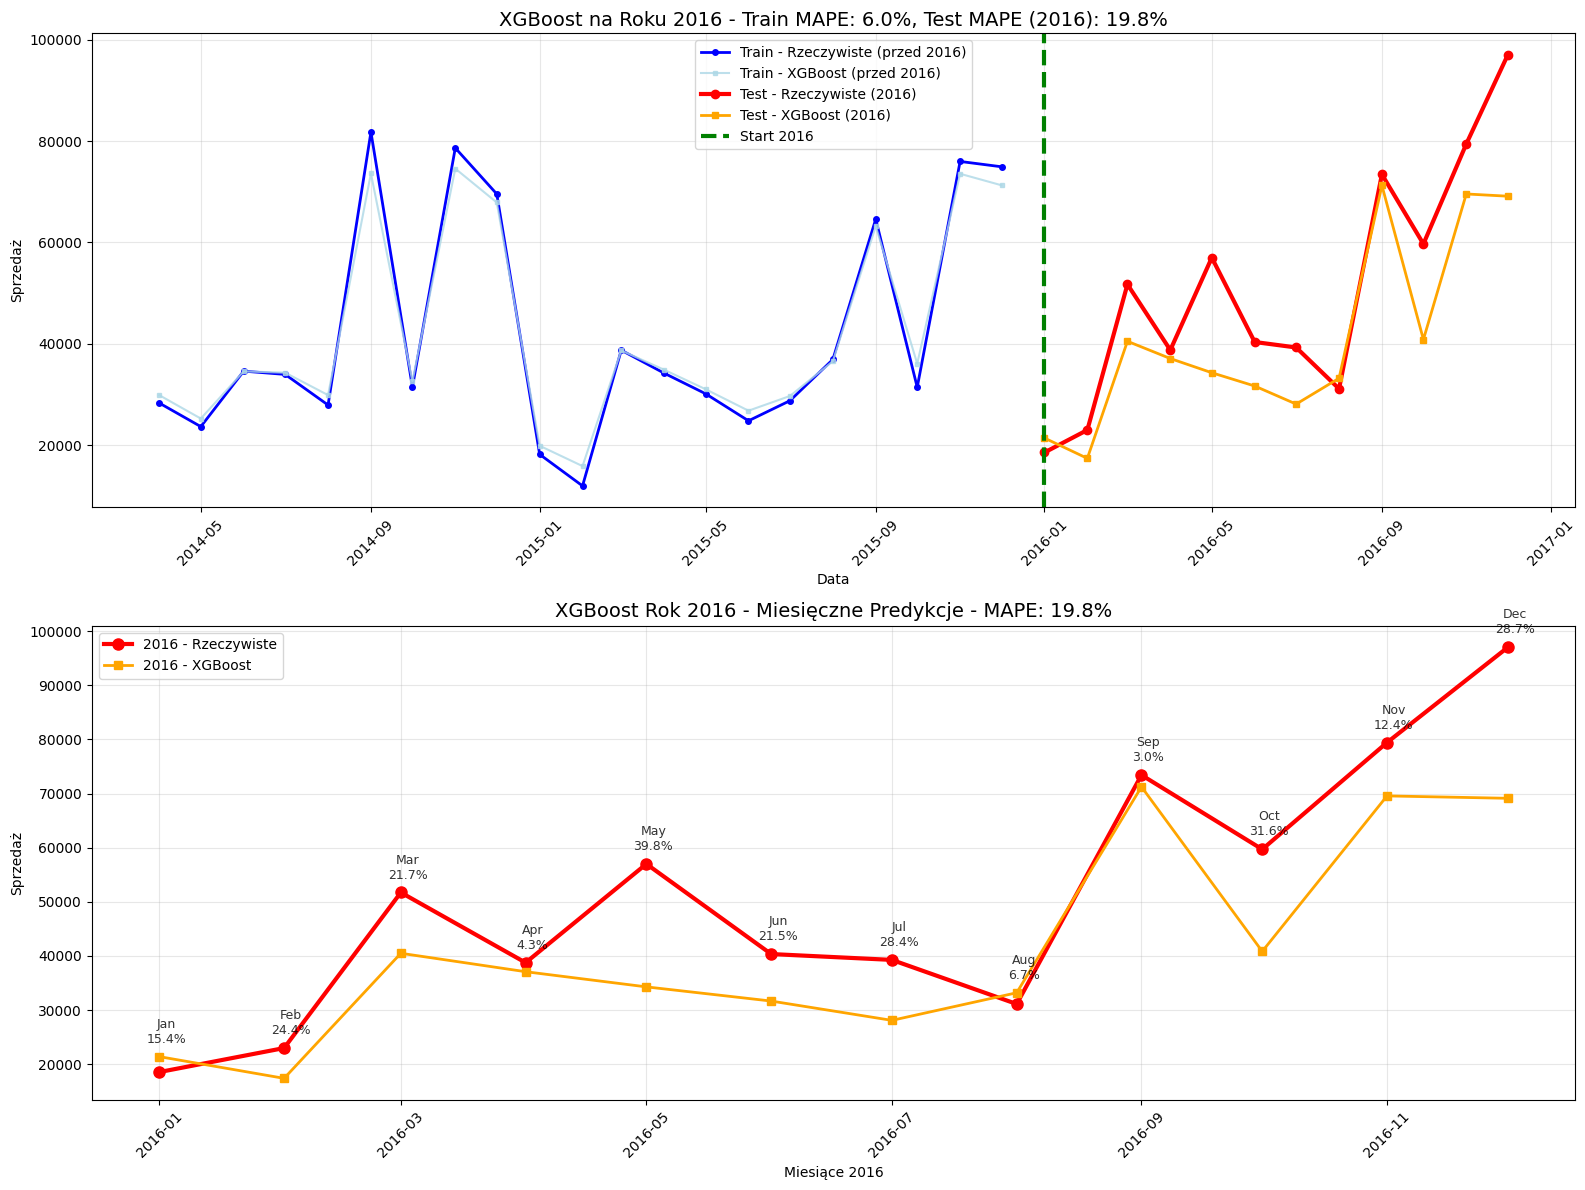

In [8]:
# TESTOWANIE ULEPSZONEGO XGBOOST NA ROKU 2016
print("=== TESTOWANIE ULEPSZONEGO XGBOOST NA ROKU 2016 ===")

print("=== TESTOWANIE NA ROKU 2016 ===")

# Podział: wszystko przed 2016 = train, cały 2016 = test
train_mask_2016 = monthly_sales['Year'] < 2016
test_mask_2016 = monthly_sales['Year'] == 2016

X_train_2016 = X[train_mask_2016]
X_test_2016 = X[test_mask_2016] 
y_train_2016 = y[train_mask_2016]
y_test_2016 = y[test_mask_2016]

print(f"Train period: {monthly_sales[train_mask_2016]['Order Month'].min()} - {monthly_sales[train_mask_2016]['Order Month'].max()}")
print(f"Test period (2016): {monthly_sales[test_mask_2016]['Order Month'].min()} - {monthly_sales[test_mask_2016]['Order Month'].max()}")
print(f"Train samples: {len(X_train_2016)}")
print(f"Test samples (2016): {len(X_test_2016)}")
# Podział: wszystko przed 2016 = train, cały 2016 = test
print(f"Train period: {monthly_sales[train_mask_2016]['Order Month'].min()} - {monthly_sales[train_mask_2016]['Order Month'].max()}")
print(f"Test period (2016): {monthly_sales[test_mask_2016]['Order Month'].min()} - {monthly_sales[test_mask_2016]['Order Month'].max()}")
print(f"Train samples: {len(X_train_2016)}")
print(f"Test samples (2016): {len(X_test_2016)}")

# OPCJA 1: Stwórz nowy model XGBoost bez early stopping dla testowania 2016
xgb_2016 = XGBRegressor(
    n_estimators=xgb_early.best_iteration if hasattr(xgb_early, 'best_iteration') else 200,
    max_depth=xgb_early.max_depth,
    learning_rate=xgb_early.learning_rate,
    subsample=xgb_early.subsample,
    reg_alpha=xgb_early.reg_alpha,
    reg_lambda=xgb_early.reg_lambda,
    random_state=42,
    verbosity=0
)


xgb_2016.fit(X_train_2016, y_train_2016)
test_preds_xgb_2016 = xgb_2016.predict(X_test_2016)
train_preds_xgb_2016 = xgb_2016.predict(X_train_2016)

# Metryki
train_mape_xgb_2016 = mean_absolute_percentage_error(y_train_2016, train_preds_xgb_2016) * 100
test_mape_xgb_2016 = mean_absolute_percentage_error(y_test_2016, test_preds_xgb_2016) * 100

print(f"\n=== WYNIKI XGBOOST NA ROKU 2016 ===")
print(f"Train MAPE (przed 2016): {train_mape_xgb_2016:.1f}%")
print(f"Test MAPE (2016):        {test_mape_xgb_2016:.1f}%")
print(f"Różnica:                 {abs(test_mape_xgb_2016 - train_mape_xgb_2016):.1f}pp")

# WIZUALIZACJA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# 1. Cała seria czasowa z podziałem na przed 2016 vs 2016
dates_train_2016 = monthly_sales[train_mask_2016]['Order Month']
dates_test_2016 = monthly_sales[test_mask_2016]['Order Month']

ax1.plot(dates_train_2016, y_train_2016, 'o-', label='Train - Rzeczywiste (przed 2016)', color='blue', markersize=4, linewidth=2)
ax1.plot(dates_train_2016, train_preds_xgb_2016, 's-', label='Train - XGBoost (przed 2016)', color='lightblue', markersize=3, alpha=0.8)
ax1.plot(dates_test_2016, y_test_2016, 'o-', label='Test - Rzeczywiste (2016)', color='red', markersize=6, linewidth=3)
ax1.plot(dates_test_2016, test_preds_xgb_2016, 's-', label='Test - XGBoost (2016)', color='orange', markersize=5, linewidth=2)

ax1.axvline(x=pd.to_datetime('2016-01-01'), color='green', linestyle='--', linewidth=3, label='Start 2016')
ax1.set_title(f'XGBoost na Roku 2016 - Train MAPE: {train_mape_xgb_2016:.1f}%, Test MAPE (2016): {test_mape_xgb_2016:.1f}%', fontsize=14)
ax1.set_xlabel('Data')
ax1.set_ylabel('Sprzedaż')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Tylko rok 2016 - szczegółowy zoom
ax2.plot(dates_test_2016, y_test_2016, 'o-', label='2016 - Rzeczywiste', color='red', markersize=8, linewidth=3)
ax2.plot(dates_test_2016, test_preds_xgb_2016, 's-', label='2016 - XGBoost', color='orange', markersize=6, linewidth=2)

# Dodaj błąd procentowy dla każdego miesiąca 2016
for i, (real, pred, date) in enumerate(zip(y_test_2016, test_preds_xgb_2016, dates_test_2016)):
    error_pct = abs(real - pred) / real * 100
    month_name = date.strftime('%b')
    ax2.annotate(f'{month_name}\n{error_pct:.1f}%', 
                xy=(date, max(real, pred)), 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize=9, 
                alpha=0.8,
                ha='center')

ax2.set_title(f'XGBoost Rok 2016 - Miesięczne Predykcje - MAPE: {test_mape_xgb_2016:.1f}%', fontsize=14)
ax2.set_xlabel('Miesiące 2016')
ax2.set_ylabel('Sprzedaż')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [9]:
# # ...existing code...

# print("=== FINALNA PREDYKCJA NA 2017 ROK (xgb_early, tylko features z treningu) ===")

# # ...existing code...

# months_2017 = pd.date_range(start='2017-01-01', periods=12, freq='MS')
# history = monthly_sales.copy()
# y_pred_2017 = []
# xgb_early = XGBRegressor(
#     n_estimators=500,
#     max_depth=10,
#     learning_rate=final_xgb.learning_rate,
#     subsample=final_xgb.subsample,
#     reg_alpha=final_xgb.reg_alpha,
#     reg_lambda=final_xgb.reg_lambda,
#     random_state=42,
#     verbosity=0
# )
# xgb_early.fit(X, y)

# for month in months_2017:
#     row = {}
#     row['Month'] = month.month
#     row['Year'] = month.year
#     row['is_december'] = int(month.month == 12)
#     row['is_january'] = int(month.month == 1)
#     row['is_q4'] = int(month.month in [10, 11, 12])
#     row['is_q1'] = int(month.month in [1, 2, 3])
#     row['lag_1'] = history['Sales'].iloc[-1]
#     row['lag_2'] = history['Sales'].iloc[-2] if len(history) > 1 else row['lag_1']
#     row['lag_3'] = history['Sales'].iloc[-3] if len(history) > 2 else row['lag_1']
#     row['time_trend'] = len(history)
#     row['month_sin'] = np.sin(2 * np.pi * month.month / 12)
#     row['month_cos'] = np.cos(2 * np.pi * month.month / 12)
#     row['is_holiday_month'] = int(month.strftime('%Y-%m') in holiday_months)
#     row['is_may'] = int(month.month == 5)
#     row['is_thanksgiving_month'] = int(month.month == 11)
#     row['is_july4_month'] = int(month.month == 7)
#     # One-hot encoding for months
#     for m in range(1, 13):
#         row[f'month_{m}'] = int(month.month == m)
#     # Zachowaj kolejność features!
#     X_row = [row[f] for f in features]
#     y_pred = xgb_early.predict(np.array(X_row).reshape(1, -1))[0]
#     y_pred_2017.append(y_pred)
#     # Dodaj predykcję do historii, by kolejne miesiące korzystały z nowych lagów
#     history = pd.concat([history, pd.DataFrame({'Order Month': [month], 'Sales': [y_pred]})], ignore_index=True)

# future_df = pd.DataFrame({
#     'Order Month': months_2017,
#     'Predicted Sales': y_pred_2017
# })

# print("\n=== PREDYKCJE NA 2017 ROK (xgb_early) ===")
# print(future_df)
# # ...existing code...

# plt.figure(figsize=(15, 7))
# plt.plot(monthly_sales['Order Month'], monthly_sales['Sales'], 'o-', label='Historyczne', color='blue')
# plt.plot(future_df['Order Month'], future_df['Predicted Sales'], 's--', label='Predykcja 2017 (xgb_early)', color='orange', linewidth=3, markersize=8)
# plt.xlabel('Data')
# plt.ylabel('Sprzedaż')
# plt.title('Predykcja XGBoost na 2017 rok (xgb_early)')
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()
# # ...existing code...

=== ROLLING FORECAST NA 2017 ROK (xgb_early, retrain co miesiąc) ===

=== ROLLING FORECAST NA 2017 ROK (xgb_early) ===
   Order Month  Predicted Sales Rolling
0   2017-01-01             36060.558594
1   2017-02-01             41082.218750
2   2017-03-01             45802.167969
3   2017-04-01             45021.175781
4   2017-05-01             47525.582031
5   2017-06-01             40187.234375
6   2017-07-01             38854.332031
7   2017-08-01             45306.402344
8   2017-09-01             75581.609375
9   2017-10-01             62126.105469
10  2017-11-01             80846.960938
11  2017-12-01             96944.757812


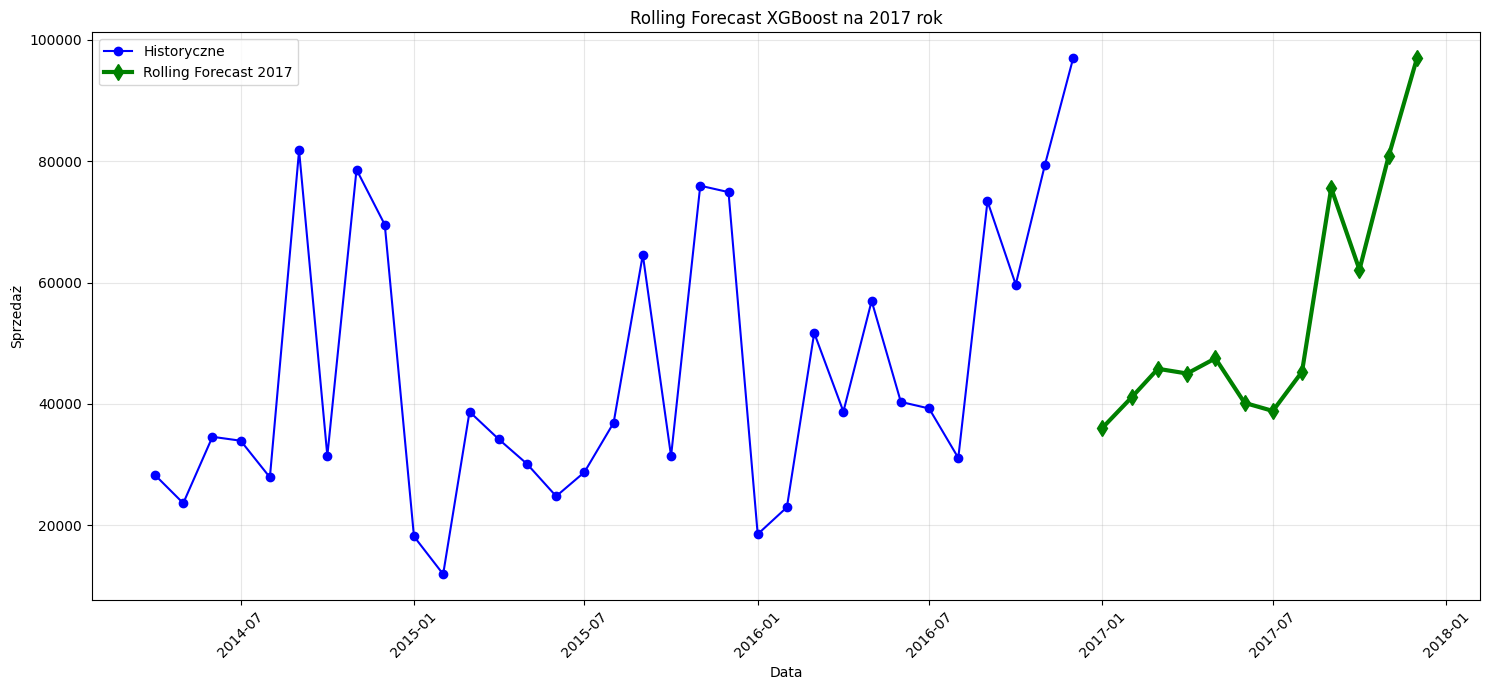

In [10]:
# ...existing code...

print("=== ROLLING FORECAST NA 2017 ROK (xgb_early, retrain co miesiąc) ===")

months_2017 = pd.date_range(start='2017-01-01', periods=12, freq='MS')
history = monthly_sales.copy()
y_pred_2017_rolling = []

for month in months_2017:
    # Przygotuj nowy wiersz z cechami na podstawie historii
    row = {}
    row['Month'] = month.month
    row['Year'] = month.year
    row['is_december'] = int(month.month == 12)
    row['is_january'] = int(month.month == 1)
    row['is_q4'] = int(month.month in [10, 11, 12])
    row['is_q1'] = int(month.month in [1, 2, 3])
    row['lag_1'] = history['Sales'].iloc[-1]
    row['lag_2'] = history['Sales'].iloc[-2] if len(history) > 1 else row['lag_1']
    row['lag_3'] = history['Sales'].iloc[-3] if len(history) > 2 else row['lag_1']
    row['time_trend'] = len(history)
    row['month_sin'] = np.sin(2 * np.pi * month.month / 12)
    row['month_cos'] = np.cos(2 * np.pi * month.month / 12)
    row['is_holiday_month'] = int(month.strftime('%Y-%m') in holiday_months)
    row['is_may'] = int(month.month == 5)
    row['is_thanksgiving_month'] = int(month.month == 11)
    row['is_july4_month'] = int(month.month == 7)
    for m in range(1, 13):
        row[f'month_{m}'] = int(month.month == m)
    X_row = [row[f] for f in features]

    # Przygotuj dane do trenowania (wszystko do tej pory)
    X_hist = history[features]
    y_hist = history['Sales']

    # Trenuj model na historii
    xgb_rolling = XGBRegressor(
        n_estimators=final_xgb.n_estimators,
        max_depth=final_xgb.max_depth,
        learning_rate=final_xgb.learning_rate,
        subsample=final_xgb.subsample,
        reg_alpha=final_xgb.reg_alpha,
        reg_lambda=final_xgb.reg_lambda,
        random_state=42,
        verbosity=0
    )
    xgb_rolling.fit(X_hist, y_hist)

    # Predykcja na kolejny miesiąc
    y_pred = xgb_rolling.predict(np.array(X_row).reshape(1, -1))[0]
    y_pred_2017_rolling.append(y_pred)

    # Dodaj predykcję do historii
    history = pd.concat([history, pd.DataFrame({'Order Month': [month], 'Sales': [y_pred]})], ignore_index=True)

# Zbierz rolling forecast do DataFrame
future_df_rolling = pd.DataFrame({
    'Order Month': months_2017,
    'Predicted Sales Rolling': y_pred_2017_rolling
})

print("\n=== ROLLING FORECAST NA 2017 ROK (xgb_early) ===")
print(future_df_rolling)

# Wykres rolling forecast vs zwykła predykcja
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales['Order Month'], monthly_sales['Sales'], 'o-', label='Historyczne', color='blue')
# plt.plot(future_df['Order Month'], future_df['Predicted Sales'], 's--', label='Predykcja 2017 (fit na całości)', color='orange', linewidth=2, markersize=7)
plt.plot(future_df_rolling['Order Month'], future_df_rolling['Predicted Sales Rolling'], 'd-', label='Rolling Forecast 2017', color='green', linewidth=3, markersize=8)
plt.xlabel('Data')
plt.ylabel('Sprzedaż')
plt.title('Rolling Forecast XGBoost na 2017 rok')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# ...existing code...

=== FINALNA PREDYKCJA NA 2017 ROK (Prophet) ===


C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
10:27:29 - cmdstanpy - INFO - Chain [1] start processing
10:27:29 - cmdstanpy - INFO - Chain [1] done processing



=== PREDYKCJE NA 2017 ROK (Prophet) ===
           ds          yhat
33 2017-01-01  33588.027896
34 2017-02-01   5452.711744
35 2017-03-01  56630.180786
36 2017-04-01  45587.828640
37 2017-05-01  53936.372937
38 2017-06-01  46660.855719
39 2017-07-01  46536.868595
40 2017-08-01  41611.426093
41 2017-09-01  85538.460551
42 2017-10-01  58785.299770
43 2017-11-01  90216.910263
44 2017-12-01  97813.380098

=== PREDYKCJE PROPHET (cały zakres) ===
           ds          yhat
0  2014-04-01  30135.670495
1  2014-05-01  30628.037591
2  2014-06-01  28607.975194
3  2014-07-01  29799.801848
4  2014-08-01  29348.203678
5  2014-09-01  69514.325018
6  2014-10-01  33948.697862
7  2014-11-01  73751.693656
8  2014-12-01  73490.398724
9  2015-01-01  16965.757191
10 2015-02-01  10484.389005
11 2015-03-01  39548.437226
12 2015-04-01  34262.035852
13 2015-05-01  27364.027007
14 2015-06-01  31116.316104
15 2015-07-01  33981.026374
16 2015-08-01  38263.925498
17 2015-09-01  74854.444108
18 2015-10-01  31348.8

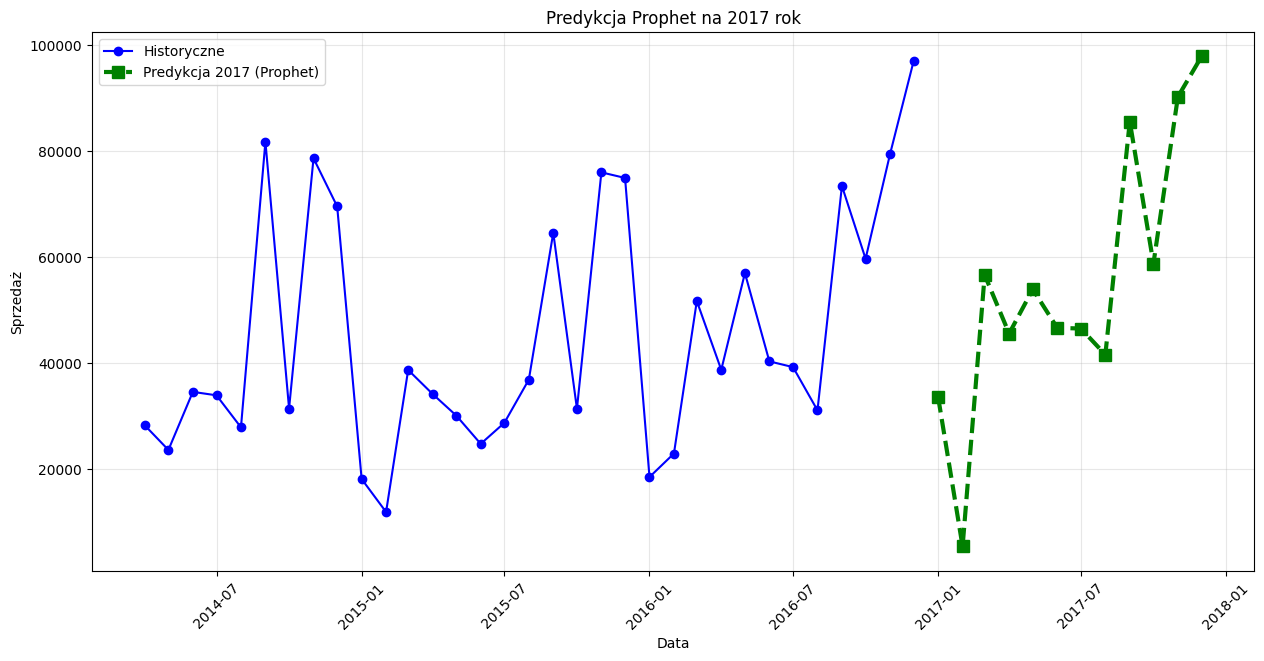

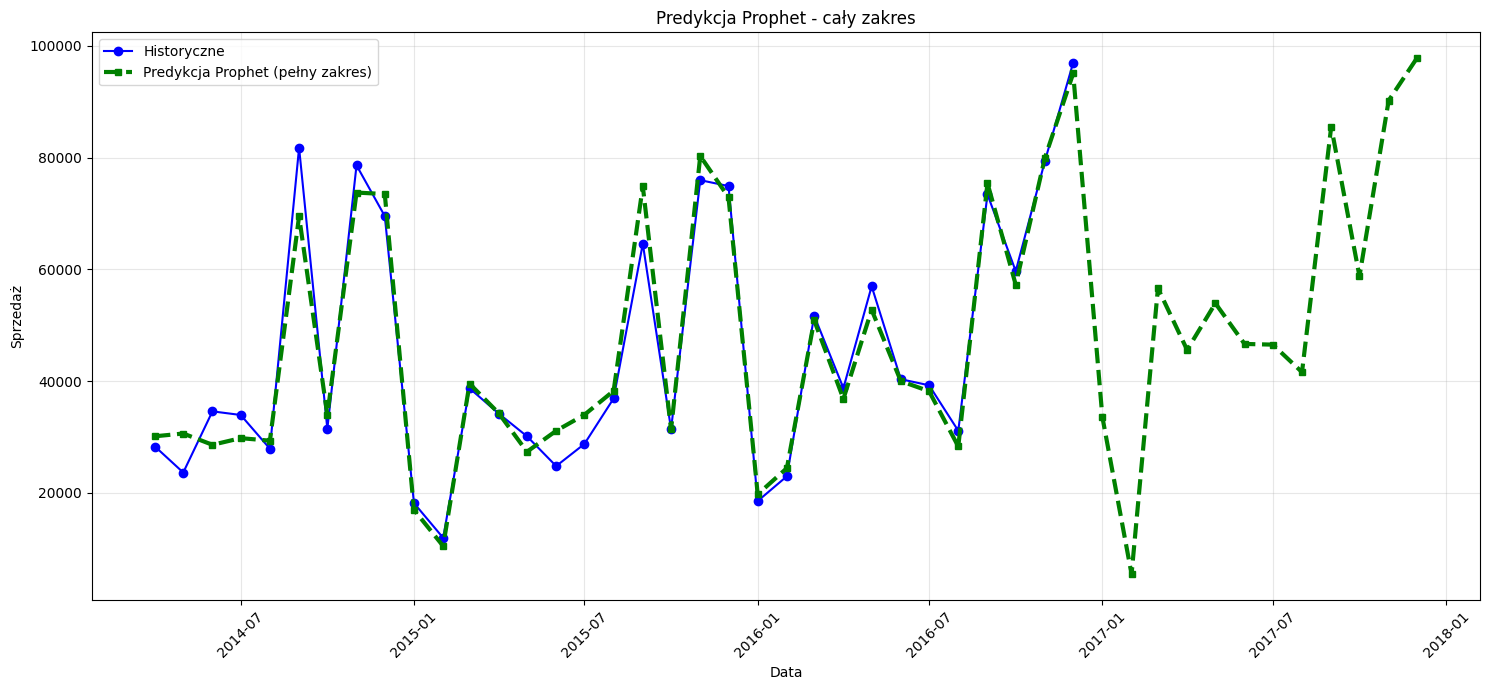

In [11]:
# FINALNA PREDYKCJA NA 2017 ROK - PROPHET

print("=== FINALNA PREDYKCJA NA 2017 ROK (Prophet) ===")

from prophet import Prophet

# Przygotuj dane dla Prophet
df_prophet = monthly_sales[['Order Month', 'Sales']].rename(columns={'Order Month': 'ds', 'Sales': 'y'})

# Inicjalizacja i trenowanie modelu
model = Prophet(yearly_seasonality=True)
model.fit(df_prophet)

# Stwórz przyszłe daty do prognozy (12 miesięcy 2017)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Wyciągnij tylko prognozy na 2017
forecast_2017 = forecast[forecast['ds'].dt.year == 2017][['ds', 'yhat']]

print("\n=== PREDYKCJE NA 2017 ROK (Prophet) ===")
print(forecast_2017)

# Wykres: cała seria + predykcja na 2017
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales['Order Month'], monthly_sales['Sales'], 'o-', label='Historyczne', color='blue')
plt.plot(forecast_2017['ds'], forecast_2017['yhat'], 's--', label='Predykcja 2017 (Prophet)', color='green', linewidth=3, markersize=8)
plt.xlabel('Data')
plt.ylabel('Sprzedaż')
plt.title('Predykcja Prophet na 2017 rok')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
# ...existing code...

# Wyświetl prognozy dla wszystkich lat (historyczne + przyszłość)
print("\n=== PREDYKCJE PROPHET (cały zakres) ===")
print(forecast[['ds', 'yhat']])

# Wykres: cała seria historyczna + predykcja Prophet (pełny zakres)
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales['Order Month'], monthly_sales['Sales'], 'o-', label='Historyczne', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], 's--', label='Predykcja Prophet (pełny zakres)', color='green', linewidth=3, markersize=5)
plt.xlabel('Data')
plt.ylabel('Sprzedaż')
plt.title('Predykcja Prophet - cały zakres')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# ...existing code...

In [12]:
# ensemble_df = pd.merge(
#     future_df[['Order Month', 'Predicted Sales']],
#     forecast_2017.rename(columns={'ds': 'Order Month', 'yhat': 'Prophet_Prediction'}),
#     on='Order Month',
#     how='inner'
# )

# # Wylicz średnią predykcję (ensemble)
# ensemble_df['Ensemble_Prediction'] = (
#     0.6 * ensemble_df['Predicted Sales'] + 0.4 * ensemble_df['Prophet_Prediction']
# )
# print("\n=== ENSEMBLE (średnia XGBoost + Prophet) na 2017 ===")
# print(ensemble_df[['Order Month', 'Predicted Sales', 'Prophet_Prediction', 'Ensemble_Prediction']])

# # Wykres porównawczy
# plt.figure(figsize=(15, 7))
# plt.plot(monthly_sales['Order Month'], monthly_sales['Sales'], 'o-', label='Historyczne', color='blue')
# plt.plot(ensemble_df['Order Month'], ensemble_df['Predicted Sales'], 's--', label='XGBoost', color='orange')
# plt.plot(ensemble_df['Order Month'], ensemble_df['Prophet_Prediction'], 'd--', label='Prophet', color='green')
# plt.plot(ensemble_df['Order Month'], ensemble_df['Ensemble_Prediction'], 'X-', label='Ensemble (średnia)', color='purple', linewidth=3, markersize=10)
# plt.xlabel('Data')
# plt.ylabel('Sprzedaż')
# plt.title('Ensemble: Średnia XGBoost + Prophet na 2017 rok')
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


=== ENSEMBLE (Rolling XGBoost + Prophet) na 2017 ===
   Order Month  Predicted Sales Rolling  Prophet_Prediction  \
0   2017-01-01             36060.558594        33588.027896   
1   2017-02-01             41082.218750         5452.711744   
2   2017-03-01             45802.167969        56630.180786   
3   2017-04-01             45021.175781        45587.828640   
4   2017-05-01             47525.582031        53936.372937   
5   2017-06-01             40187.234375        46660.855719   
6   2017-07-01             38854.332031        46536.868595   
7   2017-08-01             45306.402344        41611.426093   
8   2017-09-01             75581.609375        85538.460551   
9   2017-10-01             62126.105469        58785.299770   
10  2017-11-01             80846.960938        90216.910263   
11  2017-12-01             96944.757812        97813.380098   

    Ensemble_Prediction  
0          35071.547096  
1          26830.416729  
2          50133.375049  
3          45247.83848

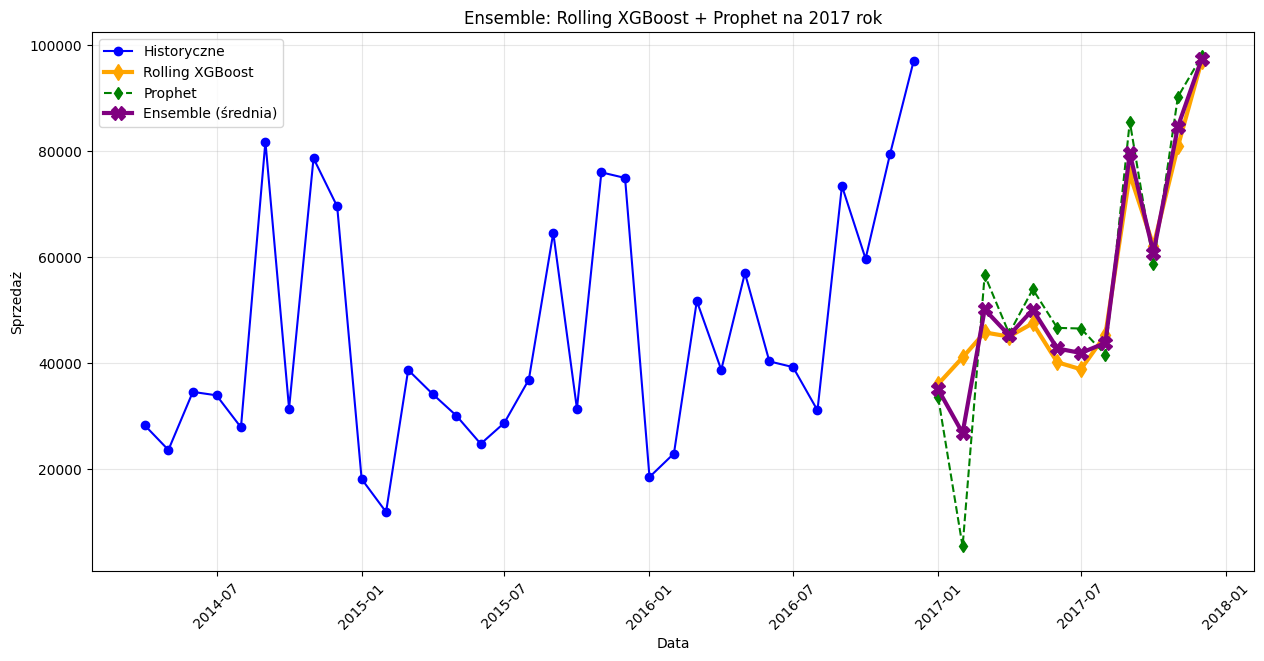

In [13]:
ensemble_df = pd.merge(
    future_df_rolling[['Order Month', 'Predicted Sales Rolling']],
    forecast_2017.rename(columns={'ds': 'Order Month', 'yhat': 'Prophet_Prediction'}),
    on='Order Month',
    how='inner'
)

# Wylicz średnią predykcję (ensemble rolling + prophet)
ensemble_df['Ensemble_Prediction'] = (
    0.6 * ensemble_df['Predicted Sales Rolling'] + 0.4 * ensemble_df['Prophet_Prediction']
)
print("\n=== ENSEMBLE (Rolling XGBoost + Prophet) na 2017 ===")
print(ensemble_df[['Order Month', 'Predicted Sales Rolling', 'Prophet_Prediction', 'Ensemble_Prediction']])

# Wykres porównawczy
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales['Order Month'], monthly_sales['Sales'], 'o-', label='Historyczne', color='blue')
plt.plot(ensemble_df['Order Month'], ensemble_df['Predicted Sales Rolling'], 'd-', label='Rolling XGBoost', color='orange', linewidth=3, markersize=8)
plt.plot(ensemble_df['Order Month'], ensemble_df['Prophet_Prediction'], 'd--', label='Prophet', color='green')
plt.plot(ensemble_df['Order Month'], ensemble_df['Ensemble_Prediction'], 'X-', label='Ensemble (średnia)', color='purple', linewidth=3, markersize=10)
plt.xlabel('Data')
plt.ylabel('Sprzedaż')
plt.title('Ensemble: Rolling XGBoost + Prophet na 2017 rok')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)